In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import numpy as np
import torch
import json
from collections import Counter

base = '/opt/ml/detection/dataset'
trainroot = os.path.join(base, 'train')
testroot = os.path.join(base, 'test')
resultroot = './results'

if not os.path.isdir(resultroot):
    os.makedirs(resultroot)

In [14]:
train_json = json.load(open(os.path.join(base, 'train.json')))
# print(train_json['annotations'][0])
print(train_json['images'][-1])

is_vis = False
for k in train_json.keys():
    print(f'{k: <14}:\t {len(train_json[k])}')

print('\n  [images]')
all_paths = train_json['images'][:3]
for path in all_paths:
    print(f'\t{path}')

print('\n  [categories]')
for v in train_json['categories']:
    print(f'\t{v["id"]}:  {v["name"]}')

print('\n  [annotations]')
annots = train_json['annotations'][:3]
for ann in annots:
    print(f'\t{ann}')

annots = train_json['annotations']
cates = []

for v in train_json['categories']:
    cates.append(v['name'])
print(f'\n{cates}')
print(train_json['categories'])

{'width': 1024, 'height': 1024, 'file_name': 'train/4882.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-23 16:20:30', 'id': 4882}
info          :	 6
licenses      :	 1
images        :	 4883
categories    :	 10
annotations   :	 23144

  [images]
	{'width': 1024, 'height': 1024, 'file_name': 'train/0000.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-26 14:44:23', 'id': 0}
	{'width': 1024, 'height': 1024, 'file_name': 'train/0001.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2021-01-10 16:30:39', 'id': 1}
	{'width': 1024, 'height': 1024, 'file_name': 'train/0002.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-27 17:55:52', 'id': 2}

  [categories]
	0:  General trash
	1:  Paper
	2:  Paper pack
	3:  Metal
	4:  Glass
	5:  Plastic
	6:  Styrofoam
	7:  Plastic bag
	8:  Battery
	9:  Clothing

  [annotations]
	{'image_id': 0, 'category_id': 0, 'area': 257301.

100%|██████████| 23144/23144 [00:00<00:00, 233470.28it/s]

0.5599999999999999
1048371.21
92863.95783831662


(4197, 71):	 71
(0, 1):	 1


TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

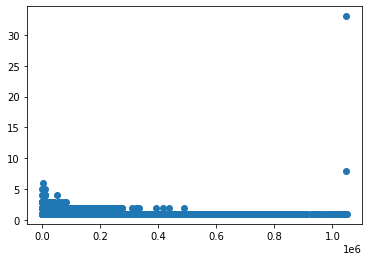

In [4]:
size_cnt = Counter()
annot_cnt = Counter()
box_size = []

for ann in tqdm(annots):
    _, _, w, h = ann['bbox']
    box_size.append(w*h)
    size_cnt.update([int(w*h/1)])
    annot_cnt.update([ann['image_id']])

# print(size_cnt)
# print(sorted(box_size))
print(min(box_size))
print(max(box_size))
print(np.mean(np.array(box_size)))
plt.scatter(list(size_cnt.keys()), list(size_cnt.values()))
print(f'{max(annot_cnt.items(), key=lambda x: x[1])}:\t {max(annot_cnt.values())}')
print(f'{min(annot_cnt.items(), key=lambda x: x[1])}:\t {min(annot_cnt.values())}')
print(np.mean(np.array(annot_cnt.values())))

[(0, 3966), (1, 6352), (2, 897), (3, 936), (4, 982), (5, 2943), (6, 1263), (7, 5178), (8, 159), (9, 468)]
Counter({1: 6352, 7: 5178, 0: 3966, 5: 2943, 6: 1263, 4: 982, 3: 936, 2: 897, 9: 468, 8: 159})
[('Battery', 159), ('Clothing', 468), ('Paper pack', 897), ('Metal', 936), ('Glass', 982), ('Styrofoam', 1263), ('Plastic', 2943), ('General trash', 3966), ('Plastic bag', 5178), ('Paper', 6352)]
[0.02503149 0.07367758 0.14121537 0.14735516 0.15459698 0.19883501
 0.46331864 0.62437028 0.81517632 1.        ]
[0.08109713 0.0841873  0.08835356 0.08872545 0.08916266 0.09180043
 0.10649633 0.11465936 0.12368177 0.13183601]
1.0


<BarContainer object of 10 artists>

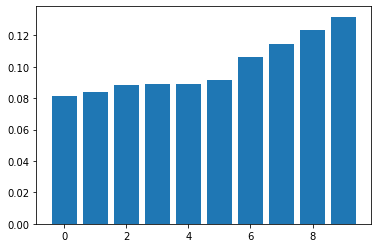

In [5]:
ann_cnt = Counter()
for ann in annots:
    ann_cnt.update([cates[int(ann['category_id'])]])

ape_cnt = Counter()
for ann in annots:
    ape_cnt.update([ann['category_id']])
ape = sorted(ape_cnt.items(), key=lambda x: x[0])
print(ape)
print(ape_cnt)

ann_cnt = sorted(ann_cnt.items(), key = lambda x: x[1], reverse=False)
print(ann_cnt)

xs, ys = [], []
for x, y in ann_cnt:
    xs.append(x)
    ys.append(y)
plt.barh(xs, ys)




In [ ]:
def minmax(arr):
    arr = arr / np.sum(arr)
    return arr

ratio = np.array(ys) / np.max(ys)
# print(ratio)
ratio = minmax(np.log(ratio + 1.9))
print(ratio)
# print(sum(ratio))
plt.bar([x for x in range(len(ratio))], ratio)

In [7]:
cls_arr = []
for idx, rat in enumerate(ratio):
    for vol in range(int(rat*5000)):
        cls_arr.append(idx)
    
cls_cnt = Counter(cls_arr)
print(cls_cnt)

Counter({9: 659, 8: 618, 7: 573, 6: 532, 5: 459, 4: 445, 3: 443, 2: 441, 1: 420, 0: 405})


In [45]:
font = ImageFont.truetype('./ubuntu.regular.ttf', 15)
color_group = {'General trash': 'orange', 'Paper': 'white', 'Paper pack': 'ivory', 'Metal': 'dimgrey', 'Glass': 'dodgerBlue', 'Plastic': 'darkolivegreen', 'Styrofoam': 'khaki', 'Plastic bag': 'Teal', 'Battery': 'lime', 'Clothing': 'fuchsia'}

def drawbox(draw, cate, pt1, pt2):
    draw.rectangle((pt1, pt2), outline=color_group[cate], width=3)
    backrec = (pt1[0]+90, pt1[1]+15)
    # draw.rectangle((pt1, backrec), outline=(0,0,0), fill=True)
    draw.text(pt1, cate, (255,255,255), font=font, backrec=True)

In [46]:
##
# visualizing annots

train_paths = glob(os.path.join(trainroot, '*'))
test_paths = glob(os.path.join(testroot, '*'))
print(f'{len(train_paths)} {len(test_paths)}')


images = train_json['images']
for image in tqdm(images):
    img = Image.open(os.path.join(base, image['file_name']))
    draw = ImageDraw.Draw(img)
    for ann in annots:
        if ann['image_id'] == image['id']:
            x,y,w,h = ann['bbox']
            pt1, pt2 = (x,y), (x+w, y+h)
            drawbox(draw, cates[ann['category_id']], pt1, pt2)
            img.save(os.path.join(resultroot, image['file_name'].split('/')[-1]))

4883 4871


 26%|██▌       | 1270/4883 [04:37<13:09,  4.58it/s]


KeyboardInterrupt: 